# Hazard assessment for heavy snowfall & blizzards

In this workflow, our aim is to understand the present probability of severe snowfall and blizzards and pinpoint the particular regions in Europe that are highly impacted. We also aim to explore how the changing climate alters the occurrence of severe snowfall and blizzards.

The assessment is done using impact-based indicators for snowfall and blizzards, which are computed using ERA5 and EURO-CORDEX data. Annual probability of heavy snowfall and blizzards is then computed. For the description of the impact-based indicators and overall methodology, please see the risk workflow description (previous page or [this page on GitHub](https://github.com/CLIMAAX/SNOW/blob/main/01_Heavy_snowfall_and_blizzards/Risk_workflow_description_SNOW_BLIZZARDS.md)).

## Preparation work

### Select area of interest
Before downloading the data, we will define the coordinates of the area of interest. Using these coordinates, we can clip the datasets for further processing and generate hazard maps for the selected area. Please also specify a name for this area, which will be used in plots and saved results.

You can use the [Bounding Box tool](https://boundingbox.klokantech.com/) to check the coordinates of your area.

 area = [Lat_north, Lon_east, Lat_south, Lon_west]

In [1]:
# Lat Lon for area interest
Lat_north = 80
Lat_south = 20
Lon_east  = -10
Lon_west  = 45

area = [Lat_north, Lon_east, Lat_south, Lon_west,]
areaname = 'Europe'

### Define parameters for the EURO-CORDEX data


In [2]:
Hist_start_year    = '1991'
Hist_end_year      = '1995'
Hist_experiment_in = 'historical'

RCP_start_year     = '2046'
RCP_end_year       = '2050'

experiment_names  =['rcp_2_6','rcp_4_5','rcp_8_5']
experiment_names1 =['rcp26','rcp45','rcp85']
experiment_choice   = 0

RCP_experiment_in  = experiment_names[experiment_choice]
RCP_experiment_in1  = experiment_names1[experiment_choice]

ensemble_member_in = 'r1i1p1'



#List of model names for download and extraction
gcm_names=['ncc_noresm1_m','mpi_m_mpi_esm_lr','cnrm_cerfacs_cnrm_cm5','cnrm_cerfacs_cnrm_cm5',
          'ncc_noresm1_m']
rcm_names=['geric_rem020150','smhi_rca4','knmi_racm022e','cnrm_aladin63','smhi_rca4']

gcm_extr_list=['NCC-NorESM1-M','MPI-M-MPI-ESM-LR','CNRM-CERFACS-CNRM-CM5',
              'CNRM-CERFACS-CNRM-CM5','NCC-NorESM1-M']
rcm_extr_list=['GERICS-REMO2015','SMHI-RCA4','KNMI-RACMO22E','CNRM-ALADIN63','SMHI-RCA4']

#Select the global and regional climate model combination you want to use
model_choice   = 1

gcm_model_in   = gcm_names[model_choice]
rcm_model_in   = rcm_names[model_choice]

gcm_model_Name = gcm_extr_list[model_choice]
rcm_model_Name = rcm_extr_list[model_choice]


print(RCP_experiment_in)
print(gcm_model_Name)
print(rcm_model_Name)

rcp_2_6
MPI-M-MPI-ESM-LR
SMHI-RCA4


### Load libraries

:::{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

- [warnings](https://docs.python.org/3/library/warnings.html) - To control the Python warning message 
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [cdsapi](https://pypi.org/project/cdsapi/) - To access the  CDS data
- [numpy](https://numpy.org) - Numerical computing tools  
- [xarray](https://docs.xarray.dev/en/stable/) - To process the NetCDF data and prepare it for further calculation
- [pyproj](https://pyproj4.github.io/pyproj/stable/) - Cartographic projections and coordinate transformations library
- [matplotlib](https://matplotlib.org/) - To plot the maps 
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - To plot the maps
:::

In [3]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

import os
import zipfile

import cdsapi
import numpy as np
np.warnings = warnings
import xarray as xr
import pyproj
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

/Users/poladesu/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
# For the rotated pole grid

#setting up the projection transformation tool
crs = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
transformer = pyproj.Transformer.from_crs('epsg:4326',crs)
Lon_east

RLON_MIN, RLAT_MIN = transformer.transform(Lat_south, Lon_east)
RLON_MAX, RLAT_MAX = transformer.transform(Lat_north, Lon_west)


##  Create the directory structure 

In order for this workflow to work we need to set up the directory structure.
Next cell will create the directory called 'snow_workflow' in the same directory where this notebook is saved.


In [5]:
workflow_folder = 'SNOW_hazard'
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

In [6]:
data_dir = os.path.join(workflow_folder,f'data_{areaname}')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

plot_dir = os.path.join(workflow_folder,f'plots_{areaname}')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

## Access and view dataset

### Download CORDEX data

We downloaded [CORDEX single level dataset](https://cds-beta.climate.copernicus.eu/datasets/projections-cordex-domains-single-levels?tab=overview)  using the CDS API from the [Copernicus Climate Data Store](https://cds-beta.climate.copernicus.eu). 

Data is accessible for the subsequent experiments: Evaluation, Historical, RCP 2.6, RCP 4.5, and RCP 8.5.

In this context, we validate the climate model using the Historical experiment against the ERA5 dataset. Furthermore, we utilize the Historical and RCP 4.5 experiments to evaluate the implications of climate change around the mid-century on heavy snowfall and blizzards.

For this demonstration, we'll guide you through the process of downloading 5-year intervals for each required variable from the EURO-CORDEX repository. In this case, we've selected the timeframe of 1991-1995 for historical data and 2046-2050 for the RCP2.6 emission scenario. We'll also specify a particular combination of General Circulation Model (GCM) and Regional Climate Model (RCM). To access the data via the API provided below, you'll need to register an account on the Copernicus CDS. A comprehensive guide on setting up the API can be found [here](https://cds-beta.climate.copernicus.eu/how-to-api). After configuring your API, replace 'KEY' with your unique key and execute the cell to commence the data download. We'll validate the climate model using the historical experiment against the ERA5 dataset. Furthermore, we'll utilize the Historical and RCP 4.5 experiments to evaluate the implications of climate change around the mid-century on heavy snowfall and blizzards



#### Download CORDEX historical data

In [ ]:
varnames_CORDEX = ['2m_air_temperature','mean_precipitation_flux','10m_wind_speed']


zip_path_cordex_Hist  = os.path.join(data_dir, f'CORDEX_EUR-11_{gcm_model_Name}_{rcm_model_Name}_{Hist_experiment_in}_{Hist_start_year}_{Hist_end_year}_{ensemble_member_in}.zip')

URL = 'https://cds-beta.climate.copernicus.eu/api/v2'
KEY = None # None # add your own
c = cdsapi.Client()
c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'domain': 'europe',
        'experiment': Hist_experiment_in,
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'daily_mean',
        'variable': varnames_CORDEX,
        'gcm_model': gcm_model_in,
        'rcm_model': rcm_model_in,
        'ensemble_member': ensemble_member_in,
        'start_year': Hist_start_year,
        'end_year': Hist_end_year,
        'format': 'zip',
    },
    zip_path_cordex_Hist)

with zipfile.ZipFile(zip_path_cordex_Hist, 'r') as zObject:
    zObject.extractall(path=data_dir)

#### Download CORDEX future climate data (RCP scenario)

In [ ]:
zip_path_cordex_RCP  = os.path.join(data_dir, f'CORDEX_EUR-11_{gcm_model_Name}_{rcm_model_Name}_{Hist_experiment_in}_{RCP_start_year}_{RCP_end_year}_{ensemble_member_in}.zip')

c = cdsapi.Client()
c.retrieve(
    'projections-cordex-domains-single-levels',
    {
        'domain': 'europe',
        'experiment': RCP_experiment_in,
        'horizontal_resolution': '0_11_degree_x_0_11_degree',
        'temporal_resolution': 'daily_mean',
        'variable': varnames_CORDEX,
        'gcm_model': gcm_model_in,
        'rcm_model': rcm_model_in,
        'ensemble_member': ensemble_member_in,
        'start_year': RCP_start_year,
        'end_year': RCP_end_year,
        'format': 'zip',
    },
    zip_path_cordex_RCP)

with zipfile.ZipFile(zip_path_cordex_RCP, 'r') as zObject:
    zObject.extractall(path=data_dir)


## Process the CORDEX data

### Convert unit of input variables 
Temperature (Kelvin) --> Temperature -273.15 (deg C)


Since CORDEX does not include a **snow depth** variable, we are inferring this variable using a straightforward relationship between precipitation and temperature. Specifically, we categorize precipitation as snow when the temperature falls below 2 degrees Celsius.

CORDEX Precipitation (PR) is in kg m-2 s-1 convert it to mm day-1. 
To do this, consider that 1 kg of PR spread over 1 m2 of surface is 1 mm in thickness and that there are 86400 seconds in one day. 

Therefore, PR (kg m-2 s-1) = PR * 86400 (mm day-1)


Snow depth(cm)  = PR [Tas < 2 deg] / 10

In [7]:
# Function to slice data with rotated coordinates
def cut_to_region(ds):
    return ds.sel(
        rlat=slice(RLAT_MIN, RLAT_MAX),
        rlon=slice(RLON_MIN, RLON_MAX)
    )

# Read the data

pr_file_hist   = f'{data_dir}/pr_EUR-11*{gcm_model_Name}*{Hist_experiment_in}*{ensemble_member_in}*{rcm_model_Name}*.nc'
pr_file_fur    = f'{data_dir}/pr_EUR-11*{gcm_model_Name}*{RCP_experiment_in1}*{ensemble_member_in}*{rcm_model_Name}*.nc'

tas_file_hist  = f'{data_dir}/tas_EUR-11*{gcm_model_Name}*{Hist_experiment_in}*{ensemble_member_in}*{rcm_model_Name}*.nc'
tas_file_fur   = f'{data_dir}/tas_EUR-11*{gcm_model_Name}*{RCP_experiment_in1}*{ensemble_member_in}*{rcm_model_Name}*.nc'

wspd_file_hist = f'{data_dir}/sfcWind_EUR-11*{gcm_model_Name}*{Hist_experiment_in}*{ensemble_member_in}*{rcm_model_Name}*.nc'
wspd_file_fur  = f'{data_dir}/sfcWind_EUR-11*{gcm_model_Name}*{RCP_experiment_in1}*{ensemble_member_in}*{rcm_model_Name}*.nc'


cordex_hist_pr_ds = xr.open_mfdataset(
    pr_file_hist,
    decode_coords='all',
    preprocess=cut_to_region)


cordex_fur_pr_ds = xr.open_mfdataset(
    pr_file_fur,
    decode_coords='all',
    preprocess=cut_to_region)


cordex_hist_tas_ds = xr.open_mfdataset(
    tas_file_hist,
    decode_coords='all',
    preprocess=cut_to_region)

cordex_fur_tas_ds = xr.open_mfdataset(
    tas_file_fur,
    decode_coords='all',
    preprocess=cut_to_region)

cordex_hist_wspd_ds = xr.open_mfdataset(
    wspd_file_hist,
    decode_coords='all',
    preprocess=cut_to_region)

cordex_fur_wspd_ds = xr.open_mfdataset(
    wspd_file_fur,
    decode_coords='all',
    preprocess=cut_to_region)

In [8]:
# Convert units

pr_hist_day = cordex_hist_pr_ds * 86400
pr_hist_day.attrs['units'] = 'mm/day'

pr_fur_day= cordex_fur_pr_ds * 86400
pr_fur_day.attrs['units'] = 'mm/day'

tas_hist_day = cordex_hist_tas_ds - 273.15
tas_hist_day.attrs['units'] = 'degC'

tas_fur_day = cordex_fur_tas_ds - 273.15
tas_fur_day.attrs['units'] = 'degC'

wspd_hist_day = cordex_hist_wspd_ds
wspd_fur_day  = cordex_fur_wspd_ds

In [10]:
# Estimate snow depth based on temperature and precipitation

# Define the temperature threshold for snow (in °C)
snow_temp_threshold = 2

# Create a temporary DataArray for the condition
snow_con_hist = tas_hist_day['tas'] < snow_temp_threshold

# Calculate snow depth based on temperature and precipitation
snow_depth_hist_day = xr.where(snow_con_hist, pr_hist_day * 10, 0)

# Create a temporary DataArray for the condition
snow_con_fur = tas_fur_day['tas'] < snow_temp_threshold

# Calculate snow depth based on temperature and precipitation
snow_depth_fur_day = xr.where(snow_con_fur, pr_fur_day * 10, 0)

### Calculate the probability of occurence for impact-based indicators based on EURO-CORDEX data

#### Define thresholds for heavy snowfall & blizzards indicators

**Thresholds for Blizzard days**

Temperature threshold --> lim_tas    = 0.

Snow threshold          -->lim_snow10 = 10.

Wind gust threshold   -->lim_gust   = 17.


**Heavy Snow thresholds** 

Snow exceding 6cm threshold  -->lim_snow6  = 6.

Snow exceding 25cm threshold -->lim_snow25 = 25.

In [11]:
#| Define thresholds for impact-based indicators (see methodology description)
lim_tas    = 0.
lim_snow10 = 10.
lim_gust   = 17.

lim_snow6  = 6.
lim_snow25 = 25.

In [12]:
# Calculate indices for CORDEX
total_days_per_year_hist = snow_depth_hist_day.groupby('time.year').count(dim='time')
total_days_per_year_fur  = snow_depth_fur_day.groupby('time.year').count(dim='time')

Historical

In [13]:
# The probability of occurrence of at least one blizzard day
out_file   = f'{data_dir}/BdayCount_AnaProb_mean_{gcm_model_Name}_{rcm_model_Name}_{Hist_experiment_in}_{ensemble_member_in}_{Hist_start_year}_{Hist_end_year}.nc'

BdayCount_hist = (
    (tas_hist_day['tas'] < lim_tas)
    * (snow_depth_hist_day['pr'] > lim_snow10)
    * (wspd_hist_day['sfcWind'] > lim_gust)
).groupby('time.year').sum('time')

BdayCount_anaProb_hist = (BdayCount_hist / total_days_per_year_hist) * 100
BdayCount_anaProb_hist = BdayCount_anaProb_hist.where(BdayCount_anaProb_hist != 0.)
BdayCount_anaProb_hist = BdayCount_anaProb_hist.assign_attrs(units="%", long_name="Annual probability of blizzard days")
BdayCount_anaProb_hist = BdayCount_anaProb_hist.rename({'pr': 'blizzard_days'})

BdayCount_anaProb_hist_mean = BdayCount_anaProb_hist.mean('year')
BdayCount_anaProb_hist_mean.to_netcdf(out_file)
del out_file

In [14]:
out_file   = f'{data_dir}/Snow_depth_hist_day_{gcm_model_Name}_{rcm_model_Name}_{Hist_experiment_in}_{ensemble_member_in}_{Hist_start_year}_{Hist_end_year}.nc'

snow_depth_hist_day.to_netcdf(out_file)

del out_file

In [15]:
# Probability of occurrence of at least one day with snowfall > 6cm
out_file   = f'{data_dir}/Snow6Prob_annual_mean_{gcm_model_Name}_{rcm_model_Name}_{Hist_experiment_in}_{ensemble_member_in}_{Hist_start_year}_{Hist_end_year}.nc'

snow6Count_anaProb_hist = (snow_depth_hist_day > lim_snow6).groupby('time.year').sum('time')

snow6Prob_annual_hist = (snow6Count_anaProb_hist / total_days_per_year_hist) * 100
snow6Prob_annual_hist = snow6Prob_annual_hist.where(snow6Prob_annual_hist != 0.)
snow6Prob_annual_hist = snow6Prob_annual_hist.assign_attrs(units="%", long_name="Annual probability of snow days")
snow6Prob_annual_hist = snow6Prob_annual_hist.rename({'pr': 'snow_days'})
#snow6Prob_annual_hist = snow6Prob_annual_hist.to_dataset(name='snow_days')

snow6Prob_annual_hist_mean = snow6Prob_annual_hist.mean('year')
snow6Prob_annual_hist_mean.to_netcdf(out_file)
del out_file

In [16]:
# Probability of occurrence of at least one day with snowfall > 25cm

out_file   = f'{data_dir}/Snow25Prob_annual_mean_{gcm_model_Name}_{rcm_model_Name}_{Hist_experiment_in}_{ensemble_member_in}_{Hist_start_year}_{Hist_end_year}.nc'

snow25Count_anaProb_hist = (snow_depth_hist_day > lim_snow25).groupby('time.year').sum('time')

snow25Prob_annual_hist = (snow25Count_anaProb_hist / total_days_per_year_hist) * 100
snow25Prob_annual_hist = snow25Prob_annual_hist.where(snow25Prob_annual_hist != 0.)
snow25Prob_annual_hist = snow25Prob_annual_hist.assign_attrs(units="%", long_name="Annual probability of snow days")
snow25Prob_annual_hist = snow25Prob_annual_hist.rename({'pr': 'snow_days'})
#snow25Prob_annual_hist = snow25Prob_annual_hist.to_dataset(name='snow_days')

snow25Prob_annual_hist_mean = snow25Prob_annual_hist.mean('year')
snow25Prob_annual_hist_mean.to_netcdf(out_file)
del out_file

Future

In [17]:
# The probability of occurrence of at least one blizzard day
out_file   = f'{data_dir}/BdayCount_AnaProb_mean_{gcm_model_Name}_{rcm_model_Name}_{RCP_experiment_in1}_{ensemble_member_in}_{RCP_start_year}_{RCP_end_year}.nc'

BdayCount_fur = (
    (tas_fur_day['tas'] < lim_tas)
    * (snow_depth_fur_day['pr'] > lim_snow10)
    * (wspd_fur_day['sfcWind'] > lim_gust)
).groupby('time.year').sum('time')

BdayCount_anaProb_fur = (BdayCount_fur / total_days_per_year_fur) * 100
BdayCount_anaProb_fur = BdayCount_anaProb_fur.where(BdayCount_anaProb_fur != 0.)
BdayCount_anaProb_fur = BdayCount_anaProb_fur.assign_attrs(units="%", long_name="Annual probability of blizzard days")
BdayCount_anaProb_fur = BdayCount_anaProb_fur.rename({'pr': 'blizzard_days'})

BdayCount_anaProb_fur_mean = BdayCount_anaProb_fur.mean('year')
BdayCount_anaProb_fur_mean.to_netcdf(out_file)
del out_file

In [18]:
out_file   = f'{data_dir}/Snow_depth_day_{gcm_model_Name}_{rcm_model_Name}_{RCP_experiment_in1}_{ensemble_member_in}_{RCP_start_year}_{RCP_end_year}.nc'

snow_depth_fur_day.to_netcdf(out_file)
del out_file

In [19]:
# Probability of occurrence of at least one day with snowfall > 6cm
out_file   = f'{data_dir}/Snow6Prob_annual_mean_{gcm_model_Name}_{rcm_model_Name}_{RCP_experiment_in1}_{ensemble_member_in}_{RCP_start_year}_{RCP_end_year}.nc'

snow6Count_anaProb_fur = (snow_depth_fur_day > lim_snow6).groupby('time.year').sum('time')

snow6Prob_annual_fur = (snow6Count_anaProb_fur / total_days_per_year_fur) * 100
snow6Prob_annual_fur = snow6Prob_annual_fur.where(snow6Prob_annual_fur != 0.)
snow6Prob_annual_fur = snow6Prob_annual_fur.assign_attrs(units="%", long_name="Annual probability of snow days")
snow6Prob_annual_fur = snow6Prob_annual_fur.rename({'pr': 'snow_days'})
#snow6Prob_annual_fur = snow6Prob_annual_fur.to_dataset(name='snow_days')

snow6Prob_annual_fur_mean = snow6Prob_annual_fur.mean('year')
snow6Prob_annual_fur_mean.to_netcdf(out_file)
del out_file

In [20]:
# Probability of occurrence of at least one day with snowfall > 25cm
out_file   = f'{data_dir}/Snow25Prob_annual_mean_{gcm_model_Name}_{rcm_model_Name}_{RCP_experiment_in1}_{ensemble_member_in}_{RCP_start_year}_{RCP_end_year}.nc'

snow25Count_anaProb_fur = (snow_depth_fur_day > lim_snow25).groupby('time.year').sum('time')

snow25Prob_annual_fur = (snow25Count_anaProb_fur / total_days_per_year_fur) * 100
snow25Prob_annual_fur = snow25Prob_annual_fur.where(snow25Prob_annual_fur != 0.)
snow25Prob_annual_fur = snow25Prob_annual_fur.assign_attrs(units="%", long_name="Annual probability of snow days")
snow25Prob_annual_fur = snow25Prob_annual_fur.rename({'pr': 'snow_days'})
#snow25Prob_annual_fur = snow25Prob_annual_fur.to_dataset(name='snow_days')

snow25Prob_annual_fur_mean = snow25Prob_annual_fur.mean('year')
snow25Prob_annual_fur_mean.to_netcdf(out_file)
del out_file

## Download ERA5 and load data into memory

We downloaded [ERA5 single level dataset](https://cds-beta.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=overview)  using the CDS API from the [Copernicus Climate Data Store](https://cds-beta.climate.copernicus.eu). We require several variables to calculate these indicator, which are at an hourly frequency. Consequently, this analysis is limited to the data period from 1991 to 2010.

We are currently retrieving data for demonstration purposes only at 00:00, 06:00, 12:00, and 18:00 UTC. However, it is feasible to obtain data for all 24 time steps. It is important to mention that we are focusing only on 4 time steps with a 6-hour interval in the analysis below, because this reduces the accuracy of the results.

In [21]:
path_ERA5   = f'{data_dir}/ERA5_data_{Hist_start_year}_{Hist_end_year}.nc'

In [ ]:
c = cdsapi.Client()
#c = cdsapi.Client(url=URL,key=KEY)
day_range=np.arange(1,32)
month_range=np.array((1,2,3,10,11,12))
varnames_ERA5=['2m_temperature','10m_wind_gust_since_previous_post_processing','snow_depth','snow_density']

dataset = 'reanalysis-era5-single-levels'

# API request
params = {'data_format': 'netcdf',
        'product_type': 'reanalysis',
        'variable': varnames_ERA5,
        'year': list(map(str, range(int(Hist_start_year), int(Hist_end_year)))),
        'month': list(map("{:02d}".format, range(1,13))),
        'time': ['00:00', '06:00', '12:00', '18:00', ],
        'day': list(np.char.zfill(list(map(str, day_range)),2)),
        'grid': [0.25, 0.25],
        'area':area,}

# Submit request and download file
fl = c.retrieve(dataset, params, path_ERA5)

In [ ]:
# Open the downloaded dataset
ds = xr.open_dataset(path_ERA5, chunks="auto")
ds = ds.rename({ "valid_time": "time" })

## Process the ERA5 data

### Convert unit of input variables 
Temperature (Kelvin) --> Temperature -273.15 (deg C)

Snow depth  (m of water equivalent)  -->Snow depth (cm) 

   Snow depth (m) = (RW X SD) / RSN
   
     where:
      SD= snow depth in m of water equivalent
      RW, density of water, = 1000 kg/m3
      RSN = density of snow in kg/m3
 Snow depth (cm) --> Snow depth (m) X 100

In [ ]:
ds['t2m']  = ds['t2m'] - 273.15
ds['t2m']  = ds['t2m'].assign_attrs(units="degC")

ds['snow_depth'] = 1000 * ds.sd / ds.rsn
ds = ds.drop_vars(['sd', 'rsn'])

ds['snow_depth'] = ds.snow_depth.assign_attrs(units="m", description="snow depth")
ds['snow_depth'] = ds['snow_depth']*100
ds['snow_depth'] = ds['snow_depth'].assign_attrs(units="cm")

###  Resampling to daily data

According to the ERA5 convention, accumulated variables aggregate data from 00 UTC to the next 24 hours (i.e., the accumulation at 00 UTC represents the sum of values during the previous day). Therefore, before archiving accumulated variables, we shifted the time axis by one timestep to ensure that the accumulations at 00 UTC correspond to the actual day.


In [ ]:
ds = ds.shift(time=1)

tas_day_ERA        = ds.t2m.resample(time='24H').mean('time')
wspd_day_ERA       = ds.fg10.resample(time='24H').max('time')
snow_depth_day_ERA = ds.snow_depth.resample(time='24H').mean('time')

### Calculate the probability of occurence ERA5

In [ ]:
# Calculate indices for ERA5
out_file   = f'{data_dir}/BdayCount_AnaProb_mean_ERA5_{Hist_start_year}_{Hist_end_year}.nc'

# The probability of occurrence of at least one blizzard day
BdayCount_anaProb_ERA = (
    (tas_day_ERA < lim_tas)
     * (snow_depth_day_ERA > lim_snow10)
     * (wspd_day_ERA > lim_gust)
).groupby('time.year').sum('time')

total_days_per_year_ERA = snow_depth_day_ERA.groupby('time.year').count(dim='time')

BdayCount_anaProb_ERA = (BdayCount_anaProb_ERA / total_days_per_year_ERA) * 100
BdayCount_anaProb_ERA = BdayCount_anaProb_ERA.where(BdayCount_anaProb_ERA != 0.)
BdayCount_anaProb_ERA = BdayCount_anaProb_ERA.assign_attrs(units="%", long_name="Annual probability of blizzard days")
BdayCount_anaProb_ERA = BdayCount_anaProb_ERA.to_dataset(name='blizzard_days')

BdayCount_anaProb_mean_ERA = BdayCount_anaProb_ERA.mean('year')
BdayCount_anaProb_mean_ERA.to_netcdf(out_file)

del BdayCount_anaProb_ERA, out_file


In [ ]:
# Probability of occurrence of at least one day with snowfall > 6cm
out_file   = f'{data_dir}/Snow6Prob_annual_mean_ERA5_{Hist_start_year}_{Hist_end_year}.nc'

snow6Count_anaProb_ERA = (snow_depth_day_ERA > lim_snow6).groupby('time.year').sum('time')

snow6Prob_annual_ERA = (snow6Count_anaProb_ERA / total_days_per_year_ERA) * 100
snow6Prob_annual_ERA = snow6Prob_annual_ERA.where(snow6Prob_annual_ERA != 0.)
snow6Prob_annual_ERA = snow6Prob_annual_ERA.assign_attrs(units="%", long_name="Annual probability of snow days")
snow6Prob_annual_ERA = snow6Prob_annual_ERA.to_dataset(name='snow_days')

snow6Prob_annual_mean_ERA = snow6Prob_annual_ERA.mean('year')
snow6Prob_annual_mean_ERA.to_netcdf(out_file)

del snow6Prob_annual_ERA, out_file

In [ ]:
# Probability of occurrence of at least one day with snowfall > 25cm
out_file   = f'{data_dir}/Snow25Prob_annual_mean_ERA5_{Hist_start_year}_{Hist_end_year}.nc'

snow25Count_anaProb_ERA = (snow_depth_day_ERA > lim_snow25).groupby('time.year').sum('time')

snow25Prob_annual_ERA = (snow25Count_anaProb_ERA / total_days_per_year_ERA) * 100

snow25Prob_annual_ERA = snow25Prob_annual_ERA.where(snow25Prob_annual_ERA != 0.)
snow25Prob_annual_ERA = snow25Prob_annual_ERA.assign_attrs(units="%", long_name="Annual probability of snow days")
snow25Prob_annual_ERA = snow25Prob_annual_ERA.to_dataset(name='snow_days')

snow25Prob_annual_mean_ERA = snow25Prob_annual_ERA.mean('year')
snow25Prob_annual_mean_ERA.to_netcdf(out_file)

del snow25Prob_annual_ERA, out_file

In [22]:
Snow25Prob_file = f'{data_dir}/Snow25Prob_annual_mean_ERA5_1991_1995.nc'
Snow6Prob_file = f'{data_dir}/Snow6Prob_annual_mean_ERA5_1991_1995.nc'
BdayCount_file = f'{data_dir}/BdayCount_AnaProb_mean_ERA5_1991_1995.nc'

snow25Prob_annual_mean_ERA = xr.open_mfdataset(Snow25Prob_file)
snow6Prob_annual_mean_ERA = xr.open_mfdataset(Snow6Prob_file)
BdayCount_anaProb_mean_ERA = xr.open_mfdataset(BdayCount_file)

## Visualize the hazard data
Having acquired the data and computed the required indicator, we proceed to create visual plots for data exploration. 

### Annual probability plot of indicator


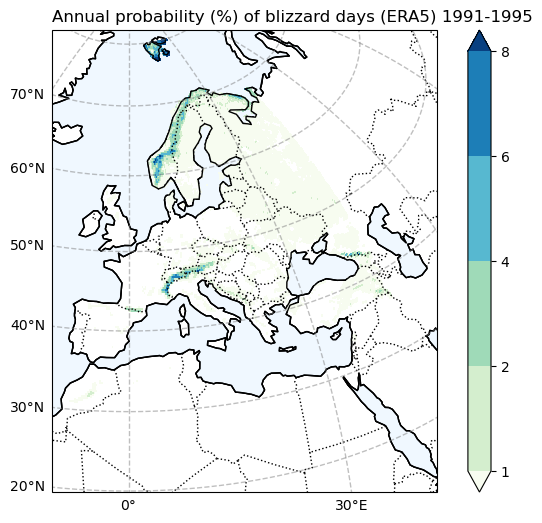

In [23]:
# Blizzard plot for ERA5

np.warnings.filterwarnings('ignore')
fig = plt.figure(figsize=(8, 6))
p_levels = [ 1,2,4,6,8]

p = BdayCount_anaProb_mean_ERA.blizzard_days.plot(
    subplot_kws=dict(projection=ccrs.Orthographic(0, 35)),
    levels=p_levels,
    cbar_kwargs={"label": "  "},
    cmap="GnBu",
    transform=ccrs.PlateCarree(),
)
p.axes.coastlines()
plt.title(f'Annual probability (%) of blizzard days (ERA5) {Hist_start_year}-{Hist_end_year}', loc = "left")

# Add coastlines and features
p.axes.add_feature(cfeature.BORDERS, linestyle=':')
p.axes.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
p.axes.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='aliceblue')

# Add latitude and longitude labels
gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

fileout = os.path.join(plot_dir,f'Annual_probability_of_blizzard_days_ERA5_{Hist_start_year}_{Hist_end_year}.png'.format(areaname))
fig.savefig(fileout)

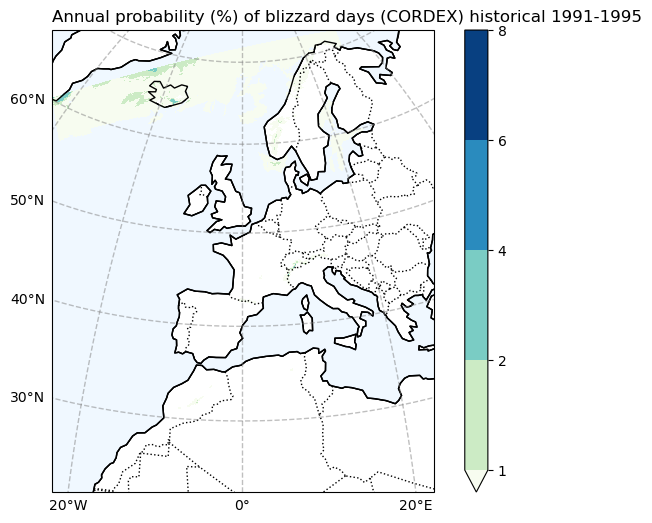

In [24]:
# Blizzard plot for CORDEX

p_levels = [ 1,2,4, 6,8]
# Define the rotated pole
pole_latitude = 39.25
pole_longitude = -162

# Plot the data
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.Orthographic(0, 35))

BdayCount_anaProb_hist_mean = BdayCount_anaProb_hist_mean.drop_vars(['rotated_pole','height'])
p = BdayCount_anaProb_hist_mean.blizzard_days.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), levels=p_levels, cbar_kwargs={"label": ""}, cmap='GnBu', add_colorbar=True)

# Add coastlines
ax.coastlines()

# Add title
plt.title(f'Annual probability (%) of blizzard days (CORDEX) {Hist_experiment_in} {Hist_start_year}-{Hist_end_year}', loc="left")

# Add coastlines and features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='aliceblue')

# Add latitude and longitude labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

fileout = os.path.join(plot_dir,f'Annual_probability_of_blizzard_days_hist_{gcm_model_Name}_{rcm_model_Name}_{Hist_experiment_in}_{ensemble_member_in}_{Hist_start_year}_{Hist_end_year}.png'.format(areaname))
fig.savefig(fileout)


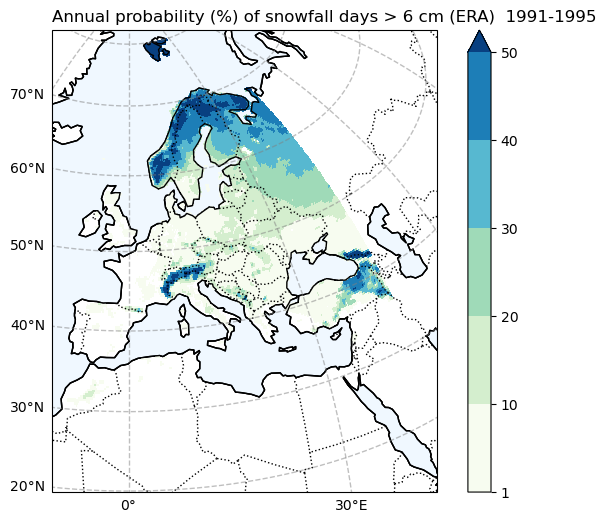

In [25]:
# Probability of snowfall days > 6 cm (ERA)
# Filter the data to exclude values less than 1
filtered_data = snow6Prob_annual_mean_ERA.snow_days.where(snow6Prob_annual_mean_ERA.snow_days >= 1)

fig = plt.figure(figsize=(8, 6))
p_levels = [1, 10, 20, 30, 40, 50]

p = filtered_data.plot(
    subplot_kws=dict(projection=ccrs.Orthographic(0, 35)),
    levels=p_levels,
    cmap="GnBu",
    cbar_kwargs={"label": " "},
    transform=ccrs.PlateCarree(),
)

p.axes.coastlines()
plt.title(f'Annual probability (%) of snowfall days > 6 cm (ERA)  {Hist_start_year}-{Hist_end_year}', loc="left")

# Add coastlines and features
p.axes.add_feature(cfeature.BORDERS, linestyle=':')
p.axes.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
p.axes.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='aliceblue')

# Add latitude and longitude labels
gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
fileout = os.path.join(plot_dir,f'Annual_probability_of_snowfall_days_6cm_ERA_{Hist_start_year}_{Hist_end_year}.png'.format(areaname))
fig.savefig(fileout)

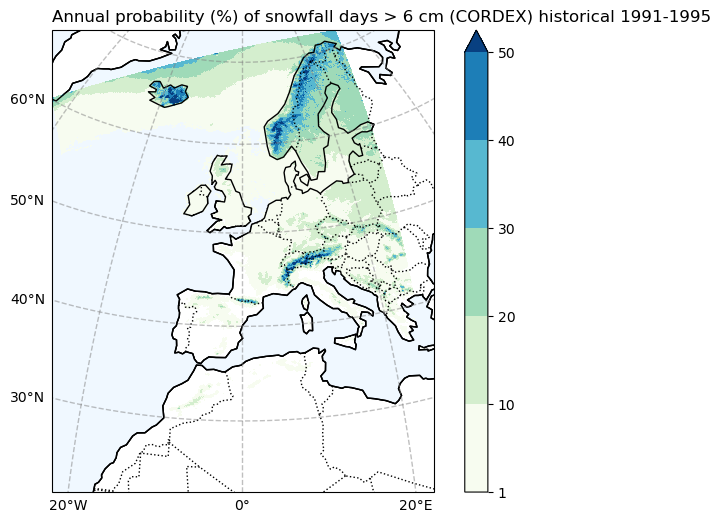

In [26]:
# Probability of snowfall days > 6 cm (CORDEX)
# Filter the data to exclude values less than 1
filtered_data = snow6Prob_annual_hist_mean.snow_days.where(snow6Prob_annual_hist_mean.snow_days >= 1)

fig = plt.figure(figsize=(8, 6))
p_levels = [1, 10, 20, 30, 40, 50]


# Plot the data
ax = plt.axes(projection=ccrs.Orthographic(0, 35))

filtered_data = filtered_data.drop_vars(['rotated_pole','height'])

p = filtered_data.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), levels=p_levels, cbar_kwargs={"label": ""}, cmap='GnBu', add_colorbar=True)

# Add coastlines
ax.coastlines()

# Add title
plt.title(f'Annual probability (%) of snowfall days > 6 cm (CORDEX) {Hist_experiment_in} {Hist_start_year}-{Hist_end_year} ', loc="left")

# Add coastlines and features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='aliceblue')

# Add latitude and longitude labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

fileout = os.path.join(plot_dir,f'Annual_probability_of_snowfall_days_6cm_hist_{gcm_model_Name}_{rcm_model_Name}_{Hist_experiment_in}_{ensemble_member_in}_{Hist_start_year}_{Hist_end_year}.png'.format(areaname))
fig.savefig(fileout)


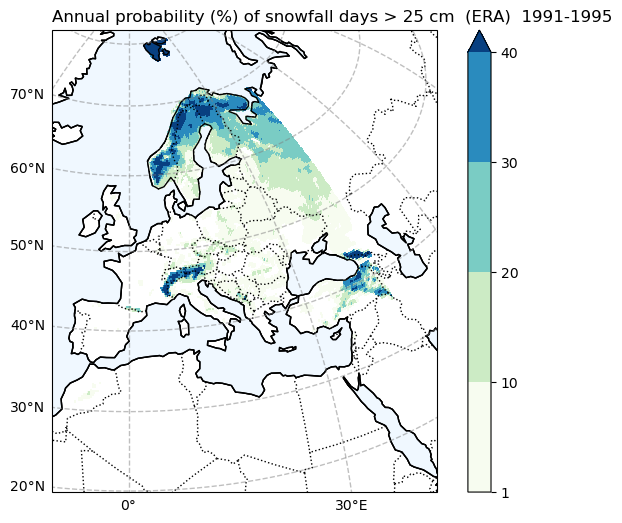

In [27]:
# Filter the data to exclude values less than 1
filtered_data = snow25Prob_annual_mean_ERA.snow_days.where(snow25Prob_annual_mean_ERA.snow_days >= 1)

fig = plt.figure(figsize=(8, 6))
p_levels = [1, 10, 20, 30, 40]

p = filtered_data.plot(
    subplot_kws=dict(projection=ccrs.Orthographic(0, 35)),
    levels=p_levels,
    cmap="GnBu",
    cbar_kwargs={"label": " "},
    transform=ccrs.PlateCarree(),
)

p.axes.coastlines()
plt.title(f'Annual probability (%) of snowfall days > 25 cm  (ERA)  {Hist_start_year}-{Hist_end_year}', loc="left")

# Add coastlines and features
p.axes.add_feature(cfeature.BORDERS, linestyle=':')
p.axes.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
p.axes.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='aliceblue')

# Add latitude and longitude labels
gl = p.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
fileout = os.path.join(plot_dir,f'Annual_probability_of_snowfall_days_25cm_ERA_{Hist_start_year}_{Hist_end_year}.png'.format(areaname))
fig.savefig(fileout)

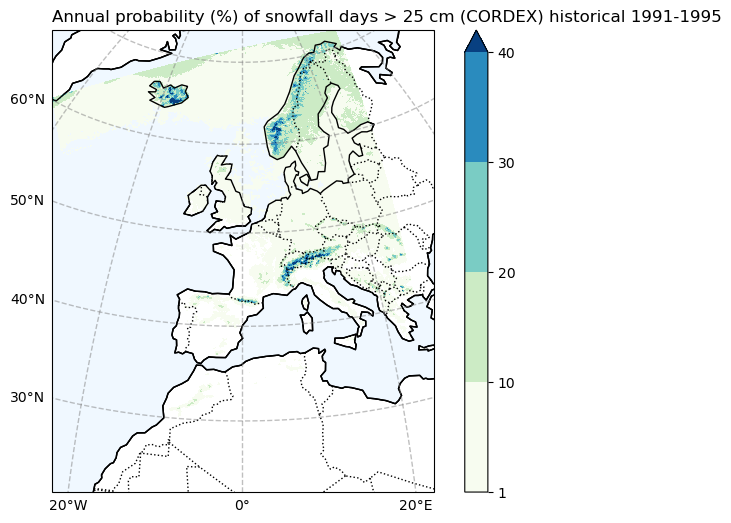

In [28]:
# Probability of snowfall days > 25 cm (CORDEX)
# Filter the data to exclude values less than 1
filtered_data = snow25Prob_annual_hist_mean.snow_days.where(snow25Prob_annual_hist_mean.snow_days >= 1)

fig = plt.figure(figsize=(8, 6))
p_levels = [1, 10, 20, 30, 40]


# Plot the data

ax = plt.axes(projection=ccrs.Orthographic(0, 35))

filtered_data = filtered_data.drop_vars(['rotated_pole','height'])

p = filtered_data.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), levels=p_levels, cbar_kwargs={"label": ""}, cmap='GnBu', add_colorbar=True)

# Add coastlines
ax.coastlines()

# Add title
plt.title(f'Annual probability (%) of snowfall days > 25 cm (CORDEX) {Hist_experiment_in} {Hist_start_year}-{Hist_end_year}', loc="left")

# Add coastlines and features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.OCEAN, edgecolor='black', facecolor='aliceblue')

# Add latitude and longitude labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

fileout = os.path.join(plot_dir,f'Annual_probability_of_snowfall_days_25cm_hist_{gcm_model_Name}_{rcm_model_Name}_{Hist_experiment_in}_{ensemble_member_in}_{Hist_start_year}_{Hist_end_year}.png'.format(areaname))
fig.savefig(fileout)


## Conclusions
In this workflow, we have demonstrated the procedure of exploring, processing, and visualizing the data required for snow and blizzard calculation.

These indices represent annual probabilities, indicating the likelihood of specific events occurring over multiple years.

The snow and blizzard hazard maps obtained and saved locally in this workflow will be utilized in the subsequent snow and blizzard risk workflow, which is a component of the risk toolbox.

Comparing the historical simulation from CORDEX with the ERA5 reanalysis, it is evident that the CORDEX model (Here, we use only one model, and utilizing multiple models for simulation may yield differing results.) notably underestimates the frequency of blizzard days and heavy snow events. It's important to note that when analyzing these indices over mountainous regions, the coarse resolution of the data may not accurately represent the topography, leading to potentially erroneous results.

## Contributors

- Suraj Polade, Finnish Meteorological Institute
- Andrea Vajda, Finnish Meteorological Institute